# Welcome to Torch study week 3~4

논문과 다르게 구현된 부분을 수정하기
- initialize (v)
- BLEU (v)
- predict (v)
- maxout (v)
- scaled-dot attention (-> 다음 달에)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.fr'), 
                                                    fields = (SRC, TRG))

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        # |hideen| = (batch_size, hid_dim * 2) 
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [11]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # input_dim : encoder_hidden_dim * 2 + decoder hidden state
        # 논문 수식 (1)의 tanh 내에 들어있는 합 수식을 concat해서 처리여기서
        # enc_hid_dim * 2 -> forward, backward encoder hidden state
        # dec_hid_dim -> decoder hidden state 

        # output_dim : decoder hidden state
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        
        # attention score를 구하기 위한 $v_a$ 벡터 곱하는 부분
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # encoder는 모든 time-step에 대한 것이 왔는데 decoder는 t(=j in paper)에서만 있어서 repeat을 해줌
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # encoder output을 batch_size가 앞으로 오도록 변경해줌
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        # hidden과 encoder_ouputs을 concat해서 처리할 수 있는 형태가 됨
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        attention = self.v(energy).squeeze(2)
        # v를 곱함으로서 [batch size, src len, 1]이 되고 마지막 차원을 squeeze해줌
        
        #attention= [batch size, src len]
        #dim = 1, 즉 src_len에 대한 softmax
        #src_len만큼 있는 decoder hidden dim 중에 뭐가 중요한지를 softmax를 통해 0~1사이 확률형태로 구함 
        return F.softmax(attention, dim=1)

## maxout

https://github.com/pytorch/pytorch/issues/805

In [12]:
class Maxout(nn.Module):

    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, 
                 trg_hid_dim, maxout_poolsize, attention):
        super().__init__()

        self.output_dim = output_dim
        
        # attention class를 input으로 받음
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        # 논문 수식 (2) 
        # input_dim : (enc_hid_dim * 2) + dec_hid_dim + emb_dim
        ## (enc_hid_dim * 2) : forward, backward hidden state from encoder $s_{i-1}$
        ## dec_hid_dim : context vector $c_{i}$
        ## emb_dim : embedding of last output vector
        self.maxout = Maxout((enc_hid_dim * 2) + dec_hid_dim + emb_dim, trg_hid_dim, maxout_poolsize)
        self.fc_out = nn.Linear(trg_hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # decoder의 forward는 지난달 seq2seq처럼 한 토큰임에 주의!
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        #output을 뽑을때 지난번의 output vector도 넣어주는데 그것은 input과 같으므로,
        #그런데 이 경우에는, teacher-forcing에서 gt를 넣어주면 gt를 넣어주는 것과 같다 
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        # 논문수식 (3) : context vector
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.maxout(torch.cat((output, weighted, embedded), dim = 1))
        prediction = self.fc_out(prediction)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

# model size

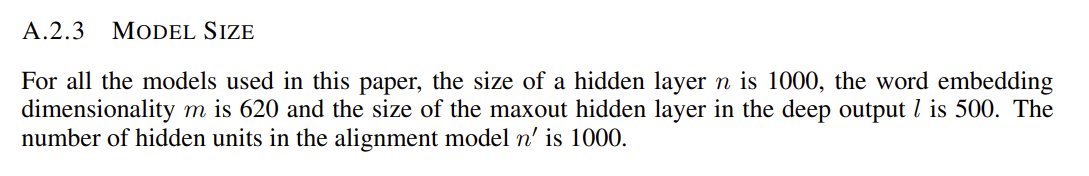

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 620 # the word embedding dimensionality
DEC_EMB_DIM = 620 # the word embedding dimensionality
ENC_HID_DIM = 1000 # the size of a hidden layer n 
DEC_HID_DIM = 1000 # the size of a hidden layer n 
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5 
MAXOUT_HID_DIM = 500 # the size of the maxout hidden layer in the deep output l
MAXOUT_POOLSIZE = 2

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, 
              MAXOUT_HID_DIM, MAXOUT_POOLSIZE, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [16]:
model.device

device(type='cuda')

# initialize

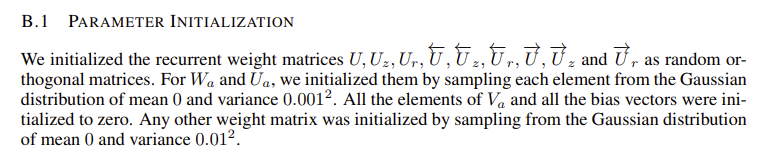

- recurrent weight matrix들은 random orthogonal matrices
- 모든 bias는 0
- $W_a$와 $U_a$는 N(0, 0.001^2)이고 bias는 0 -> 코드에서 concat되어 있는데 그냥...하나로..
- $V_a$는 다 0으로 초기화 -> $v_a$라고 일단 생각함
- 다른 weight들은 N(0, 0.01$2)

In [16]:
[name for name, param in model.named_parameters()]

['encoder.embedding.weight',
 'encoder.rnn.weight_ih_l0',
 'encoder.rnn.weight_hh_l0',
 'encoder.rnn.bias_ih_l0',
 'encoder.rnn.bias_hh_l0',
 'encoder.rnn.weight_ih_l0_reverse',
 'encoder.rnn.weight_hh_l0_reverse',
 'encoder.rnn.bias_ih_l0_reverse',
 'encoder.rnn.bias_hh_l0_reverse',
 'encoder.fc.weight',
 'encoder.fc.bias',
 'decoder.attention.attn.weight',
 'decoder.attention.attn.bias',
 'decoder.attention.v.weight',
 'decoder.embedding.weight',
 'decoder.rnn.weight_ih_l0',
 'decoder.rnn.weight_hh_l0',
 'decoder.rnn.bias_ih_l0',
 'decoder.rnn.bias_hh_l0',
 'decoder.maxout.lin.weight',
 'decoder.maxout.lin.bias',
 'decoder.fc_out.weight',
 'decoder.fc_out.bias']

In [17]:
x = torch.Tensor(5, 3)
nn.init.zeros_(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'rnn.weight' in name:
            # recurrent weight matrix 
            # orthogonal should have dim 2 or more
            nn.init.orthogonal_(param.data)
        elif 'attention.v' in name:
            nn.init.zeros_(param.data)
        elif 'attention' in name:
            nn.init.normal_(param.data, 0, 0.001 ** 2)
        elif 'weight' in name:
            nn.init.normal_(param.data, 0, 0.01 ** 2)
        else:
            nn.init.constant_(param.data, 0)
            

### main에 넣기

In [19]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 620)
    (rnn): GRU(620, 1000, bidirectional=True)
    (fc): Linear(in_features=2000, out_features=1000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=3000, out_features=1000, bias=True)
      (v): Linear(in_features=1000, out_features=1, bias=False)
    )
    (embedding): Embedding(6469, 620)
    (rnn): GRU(2620, 1000)
    (maxout): Maxout(
      (lin): Linear(in_features=3620, out_features=1000, bias=True)
    )
    (fc_out): Linear(in_features=500, out_features=6469, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 40,127,409 trainable parameters


maxout 미적용 시, The model has 21,196,869 trainable parameters<Br>
maxout 적용 시, The model has 14,631,921 trainable parameters<Br>
maxout 적용 및 논문 파라미터 적용 시, The model has 40,127,409 trainable parameters

In [21]:
optimizer = optim.Adam(model.parameters())

In [22]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# bleu score
https://cloud.google.com/translate/automl/docs/evaluate

refs : 정답<br>
sys : 후보

In [23]:
from sacrebleu import corpus_bleu, sentence_bleu

In [24]:
sys = ['The dog bit the man.', "It wasn't surprising.", 'The man had just bitten him.']
refs = [['The dog bit the man.', 'It was not unexpected.', 'The man bit him first.'],
        ['The dog had bit the man.', 'No one was surprised.', 'The man had bitten the dog.']]
bleu = corpus_bleu(sys, refs)
print(bleu.score)

48.530827009929865


In [25]:
sys = ['The dog bit the man.']
refs = [['The dog bit the man.<eos><eos><eos>'],
        ['The dog had bit the man. <eos><eos><eos><eos>']]
bleu = corpus_bleu(sys, refs, force=True)
print(bleu.score)

22.31301601484299


In [26]:
sys = ['i kill you']
refs = ['i love you']
sentence_bleu(sys, refs).score

34.66806371753173

In [27]:
for batch in train_iterator:
    src = batch.src
    trg = batch.trg
    break

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [28]:
output = model(src, trg)

In [29]:
output.shape # seq_len, batch_size, trg_token_list

torch.Size([26, 128, 6469])

In [30]:
TRG_PAD_IDX

1

In [31]:
output.argmax(-1).shape

torch.Size([26, 128])

In [32]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
TRG_special_tokens = [TRG_EOS_IDX, TRG_PAD_IDX, TRG_UNK_IDX]

In [33]:
def get_speical_token(field):
    def get_stoi(idx):
        return field.vocab.stoi[idx]
    return [get_stoi(field.pad_token), get_stoi(field.unk_token), 
            get_stoi(field.eos_token)]

In [34]:
def get_itos_str(tokens, field):
    ignore_idx = get_speical_token(field)
    return ' '.join([field.vocab.itos[token] for token in tokens
                    if token not in ignore_idx])

In [35]:
def get_itos_batch(tokens_batch, field):
    return [get_itos_str(batch, field) for batch in tokens_batch]

In [36]:
def get_bleu_score(output, trg, trg_field):
    with torch.no_grad():
        output_token = output.argmax(-1)

    # 문장 별로 해야돼서 permute 해야 함
    output_token = output_token.permute(1, 0)
    trg = trg.permute(1, 0)
    system = get_itos_batch(output_token, trg_field)
    refs = get_itos_batch(trg, trg_field)
    bleu = corpus_bleu(system, [refs], force=True).score

    return bleu

In [37]:
output.shape, trg.shape

(torch.Size([26, 128, 6469]), torch.Size([26, 128]))

In [38]:
get_bleu_score(output, trg, TRG)

0.020381222136065254

In [39]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_bleu = 0 
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        bleu = get_bleu_score(output, trg, TRG)
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)

        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_bleu += bleu
        
    return epoch_loss / len(iterator), epoch_bleu / len(iterator)

In [40]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_bleu = 0 
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            bleu = get_bleu_score(output, trg, TRG)
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)


            epoch_loss += loss.item()
            epoch_bleu += bleu
        
    return epoch_loss / len(iterator), epoch_bleu / len(iterator)

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_bleu = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, valid_bleu = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | train BLEU : {train_bleu:.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | valid BLEU : {valid_bleu:.3f}')

Epoch: 01 | Time: 4m 25s
	Train Loss: 5.151 | Train PPL: 172.528 | train BLEU : 0.420
	Val. Loss: 5.220 |  Val. PPL: 184.907 | valid BLEU : 1.964
Epoch: 02 | Time: 4m 26s
	Train Loss: 3.933 | Train PPL:  51.058 | train BLEU : 4.290
	Val. Loss: 3.913 |  Val. PPL:  50.047 | valid BLEU : 11.859
Epoch: 03 | Time: 4m 30s
	Train Loss: 2.872 | Train PPL:  17.672 | train BLEU : 13.428
	Val. Loss: 3.073 |  Val. PPL:  21.609 | valid BLEU : 26.345
Epoch: 04 | Time: 4m 18s
	Train Loss: 2.180 | Train PPL:   8.842 | train BLEU : 21.540
	Val. Loss: 2.910 |  Val. PPL:  18.350 | valid BLEU : 35.444
Epoch: 05 | Time: 4m 16s
	Train Loss: 1.809 | Train PPL:   6.106 | train BLEU : 25.467
	Val. Loss: 2.638 |  Val. PPL:  13.982 | valid BLEU : 37.575
Epoch: 06 | Time: 4m 14s
	Train Loss: 1.534 | Train PPL:   4.636 | train BLEU : 29.496
	Val. Loss: 2.619 |  Val. PPL:  13.717 | valid BLEU : 39.318
Epoch: 07 | Time: 4m 14s
	Train Loss: 1.361 | Train PPL:   3.901 | train BLEU : 32.434
	Val. Loss: 2.725 |  Val. PP

Finally, we test the model on the test set using these "best" parameters.

In [43]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_bleu = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test BLEU : {test_bleu :.3f}')

| Test Loss: 2.545 | Test PPL:  12.747 | Test BLEU : 40.328


without maxout<br>
| Test Loss: 2.577 | Test PPL:  13.162 | Test BLEU : 39.637<br>
with maxout (no parameter change) <br>
| Test Loss: 2.516 | Test PPL:  12.380 | Test BLEU : 40.204<br>
with maxout and paper parameter<br>
| Test Loss: 2.545 | Test PPL:  12.747 | Test BLEU : 40.328

# predict

In [44]:
examples = ['i like you', 'i hate you']

In [45]:
preprocessed = [SRC.preprocess(example) for example in examples]
processed = SRC.process(preprocessed)
preprocessed, processed

([['i', 'like', 'you'], ['i', 'hate', 'you']],
 tensor([[   2,    2],
         [ 956,  956],
         [ 340, 4105],
         [1145, 1145],
         [   3,    3]]))

In [46]:
# TRG_LEN 만큼 outputs이 나오기 때문에 그냥 길이를 늘여줌
processed_long = processed.repeat(4, 1) 

In [52]:
with torch.no_grad():
    outputs = model(processed.to(device), processed_long.to(device), teacher_forcing_ratio=0)

In [53]:
outputs.shape

torch.Size([20, 2, 6469])

In [54]:
predicted = torch.argmax(outputs, dim=-1)

In [55]:
predicted.T

tensor([[   0, 1557, 6158,   67, 1513, 1513, 1513, 1513,    5,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3],
        [   0, 3722,  455,    0, 1513,    0, 1513,    0,    5,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3]], device='cuda:0')

In [56]:
get_itos_batch(predicted.T, TRG)

['je sais que vous vous vous vous .', "j' pancarte vous vous ."]

je sais que vous vous vous vous . : 
I know you you you you you.<br>
j' pancarte vous vous . : I sign you you.